In [2]:
import numpy as np
import scipy as sp
import sys
dir_string = 'C:/Users/rannu/OneDrive - NTNU/Desktop/VsPython/'+\
                'Spain/NMfDS/Assignments/'
sys.path.append(dir_string + 'Ass4')
sys.path.append(dir_string + 'Ass6')
sys.path.append(dir_string + 'Ass7')
from RTBP_definitions import r1, r2, OMEGA, ODE_R3BP, Jacobi_first_integral
from custom_ODE_solver import ODE_solver
from PoincareR3BP import poincare_map_solve_ivp_R3BP

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### What to change
- rewrite and restructure
- implement your own derivative
- rewrite with your definition of radius
- remove the loop for construction, that's MATLAB-y

In [3]:
mu = 0.012
dir = -1
x0 = [1.119748482176185, 0, 0, -0.2260036463376957]
x0.extend([1, 0, 0, 0, 
           0, 1, 0, 0, 
           0, 0, 1, 0, 
           0, 0, 0, 1])  # initial conditions and identity matrix
print(x0)
time_span = 6.219656012174353 # The period of the periodic orbit

[1.119748482176185, 0, 0, -0.2260036463376957, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


1.0416089085718845
det(A) = 
 [[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 3.18338396  0.          0.          2.        ]
 [ 0.         -0.09169198 -2.          0.        ]]

eigenvalues = 
 0.5016383507584008 , -0.5016383507584007

Their respective normalized eigenvectors = 
 [-0.28940578  0.84569227 -0.14517704  0.42423167] ,
 [-0.28940578 -0.84569227  0.14517704  0.42423167]

Biggest Difference: 1.3367085216486885e-13
Solution at last time step:
 [ 1.11974848e+00  4.66419221e-13  2.26827238e-13 -2.26003646e-01]
Delta beginning and end:
 [-4.88498131e-15  4.66419221e-13  2.26827238e-13  6.38378239e-15]


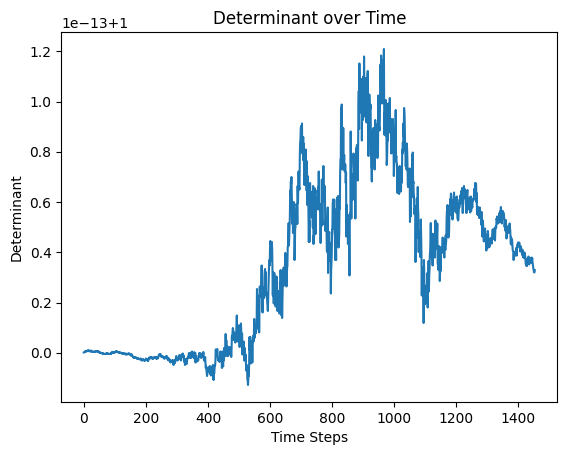

In [16]:


# Constants and initial conditions
tol = 1e-16
mu = 0.012
dir = 1
x0 = [1.119748482176185, 0, 0, -0.2260036463376957]
x0.extend([1, 0, 0, 0, 
           0, 1, 0, 0, 
           0, 0, 1, 0, 
           0, 0, 0, 1])  # initial conditions and identity matrix
time_span = 6.219656012174353

# Define the variation equation as a function of time, x, mu and direction
def variation_eq(t, x, mu, dir):
    var_eq = np.zeros(20)
    # Defining these as variables so solve_ivp can handle them
    r1_val = r1(mu, x[0], x[1])
    r2_val = r2(mu, x[0], x[1])

    var_eq[0] = x[2]
    var_eq[1] = x[3]
    var_eq[2] = 2 * x[3] + x[0] - (1 - mu) * (x[0] - mu) / r1_val**3 \
                - mu * (x[0] - mu + 1) / r2_val**3
    var_eq[3] = -2 * x[2] + x[1] * (1 - (1 - mu) / r1_val**3 - mu / r2_val**3)

    Omegaxx = 1 - (1 - mu) / r1_val**3 \
            + 3 * (1 - mu) * (x[0] - mu)**2 / r1_val**5 - mu / r2_val**3 \
            + 3 * mu * (x[0] - mu + 1)**2 / r2_val**5
    Omegayy = 1 - (1 - mu) / r1_val**3 - mu / r2_val**3 \
            + (3 * (1 - mu) * x[1]**2) / r1_val**5 \
            + (3 * mu * x[1]**2) / r2_val**5
    Omegaxy = 3 * (1 - mu) * x[1] * (x[0] - mu) / r1_val**5 \
            + 3 * mu * x[1] * (x[0] - mu + 1) / r2_val**5
    
    for i in range(4, 12):
        var_eq[i] = x[i + 8]

    for i in range(12, 16):
        var_eq[i] = Omegaxx * x[i - 8] + Omegaxy * x[i - 4] + 2 * x[i + 4]

    for i in range(16, 20):
        var_eq[i] = Omegaxy * x[i - 12] + Omegayy * x[i - 8] - 2 * x[i - 4]

    # Flip the sign of the variation equation if we are looking at the
    # stable manifold
    if dir == -1:
        var_eq = -var_eq

    return var_eq

# Solve the ODE
solution = solve_ivp(variation_eq, [0, time_span], x0, args=(mu, dir),
                      method='RK45', atol=tol, rtol=tol)

# Compute the determinant vector
deter_vector = np.array([np.linalg.det(solution.y[4:20, i].reshape(4, 4))\
                          for i in range(solution.y.shape[1])])

biggest_difference = np.max(deter_vector) - np.min(deter_vector)


from Lagrange_computations import compute_Lagrange_pt
mu = 0.1
print(compute_Lagrange_pt(mu, 3))
L3 = [compute_Lagrange_pt(mu, 3), 0, 0, 0] # where mu = 0.1
# L3 = np.array([1.0828394642022439, 0, 0, 0]) # where mu = 0.2
L3.extend([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])  # initial conditions and identity matrix
time_span = 0

# compute the Jacobian matrix of the RTBP at Li.
# The eigenvalues of this matrix are the frequencies of the periodic orbit

A = variation_eq(time_span, L3, mu, 1)[4:20].reshape(4,4)
print('det(A) = \n', A)
eigenvalues, eigenvectors = np.linalg.eig(A)
lambda_pos = eigenvalues[3].real
lambda_neg = eigenvalues[2].real
eigvec_pos = eigenvectors[:,3]
eigvec_neg = eigenvectors[:,2]
print('\neigenvalues = \n', lambda_pos, ",", lambda_neg)
print('\nTheir respective normalized eigenvectors = \n', eigvec_pos.real, \
      ",\n", eigvec_neg.real)
# Only the real part of the eigenvectors are needed


print("\nBiggest Difference:", biggest_difference)
# Print the first four indexes of the sol at the last time step
print("Solution at last time step:\n", solution.y[:, -1][:4])
print("Delta beginning and end:\n", solution.y[:, -1][:4] - solution.y[:, 0][:4])

# Plot the determinant vector
plt.plot(deter_vector)
plt.xlabel('Time Steps')
plt.ylabel('Determinant')
plt.title('Determinant over Time')
# y axis is the biggest difference
plt.ylim([np.min(deter_vector) - 0.05*biggest_difference, np.max(deter_vector) + 0.05*biggest_difference])
plt.show()

